In [124]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
# import seaborn as sns

from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
npz = np.load('/home/diego/python/generative-glm/cool_stuff/fixed_freq.npz')
t, r_te, r_fr, mask_spikes_te, mask_spikes_fr  = npz['t'], npz['r_te'], npz['r_fr'], npz['mask_spikes_te'], npz['mask_spikes_fr']

u_te, u_fr = npz['u_te'], npz['u_fr']

u0_ml, tf_eta, eta_vals_ml = npz['glm_u0'], int(npz['tf_eta']), npz['glm_eta_coefs']

dt = t[1]

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]

st_te = SpikeTrain(t, mask_spikes_te)
st_fr = SpikeTrain(t, mask_spikes_fr)

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes).double()
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr))).double()
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1)).double()
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1)).double()

ms = 1

In [127]:
# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
#     r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
        
#     norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
#     norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
#     mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
#     d = (norm2_te + norm2_fr - 2 * mean_dot)
#     return d

# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
#     norm2_te, norm2_fr, mean_dot = 0, 0, 0
#     for ii in range(n_batch_te):
#         _r_te_ii = r_te[:, ii:ii + 1]
#         _r_te = r_te[:, ii + 1:]
#         _r_fr_ii = r_fr[:, ii:ii + 1]
#         _r_fr = r_fr[:, ii + 1:]
        
#         norm2_te += torch.sum(torch.sum(_r_te_ii * _r_te, 0), 0)
#         norm2_fr += torch.sum(torch.sum(_r_fr_ii * _r_fr, 0), 0)
#         mean_dot += torch.sum(torch.sum(_r_te_ii * r_fr, 0), 0)

# #         norm2_te += torch.sum(torch.sum(_r_te_ii**4 * _r_te**4, 0), 0)
# #         norm2_fr += torch.sum(torch.sum(_r_fr_ii**4 * _r_fr**4, 0), 0)
# #         mean_dot += torch.sum(torch.sum(_r_te_ii**4 * r_fr**4, 0), 0)
        
# #         sd = 1e1
# #         norm2_te += torch.sum(torch.exp(-torch.sum((_r_te_ii - _r_te)**2, 0) / sd), 0)
# #         norm2_fr += torch.sum(torch.exp(-torch.sum((_r_fr_ii - _r_fr)**2, 0) / sd), 0)
# #         mean_dot += torch.sum(torch.exp(-torch.sum((_r_te_ii - r_fr)**2, 0) / sd), 0)
        
#     norm2_te /= (n_batch_te * (n_batch_te - 1) / 2)
#     norm2_fr /= (n_batch_fr * (n_batch_fr - 1) / 2)
#     mean_dot /= (n_batch_te * n_batch_fr)
#     d = norm2_te + norm2_fr - 2 * mean_dot
# #         _r_te = np.concatenate((r_te[:, :ii], r_te[:, ii + 1:]), 1)
# #     r_mean_te, r_mean_fr = torch.mean(r_te, 1), torch.mean(r_fr, 1)    
# #     d = torch.sum((r_mean_te - r_mean_fr)**2)
# #     d = torch.sum((r_mean_te**2 - r_mean_fr**2)**2)
# #     d = torch.sum((torch.exp(r_mean_te) - torch.exp(r_mean_fr))**2)
# #     d = torch.exp(-torch.sum((r_mean_te - r_mean_fr)**2) / 1e3)
# #     print(torch.sum((r_mean_te - r_mean_fr)**2), d)
# #     r_var_te, r_var_fr = torch.var(r_te, 1), torch.var(r_fr, 1)    
# #     d = torch.sum((r_var_te - r_var_fr)**2)
#     return d

def distance(r, mask_spikes, y):
    r_te, r_fr = r[:, y == 1], r[:, y == 0]
    mask_spikes_te, mask_spikes_fr = mask_spikes[:, y == 1].bool(), mask_spikes[:, y == 0].bool()
    n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
    mask = torch.any(mask_spikes_te, 1)
    r_te[~mask, :] = 0
    r_fr[~mask, :] = 0
    r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
    norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
    norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
    mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
    d = (norm2_te + norm2_fr - 2 * mean_dot)
    return d

 epoch 199 of 200 loss 5337.0804

Text(0.5, 0, '# spikes')

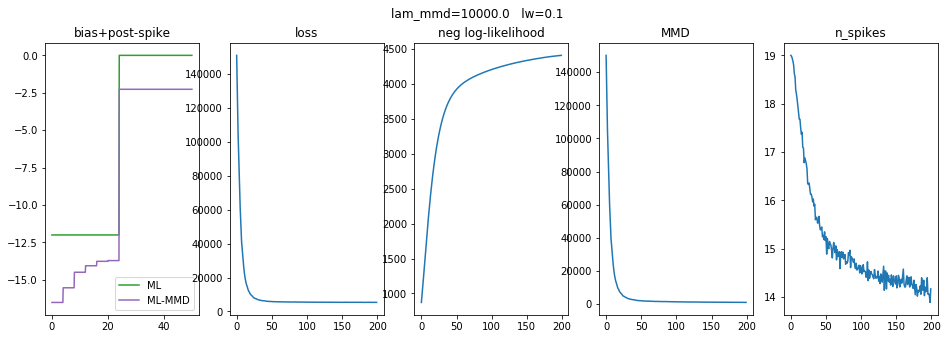

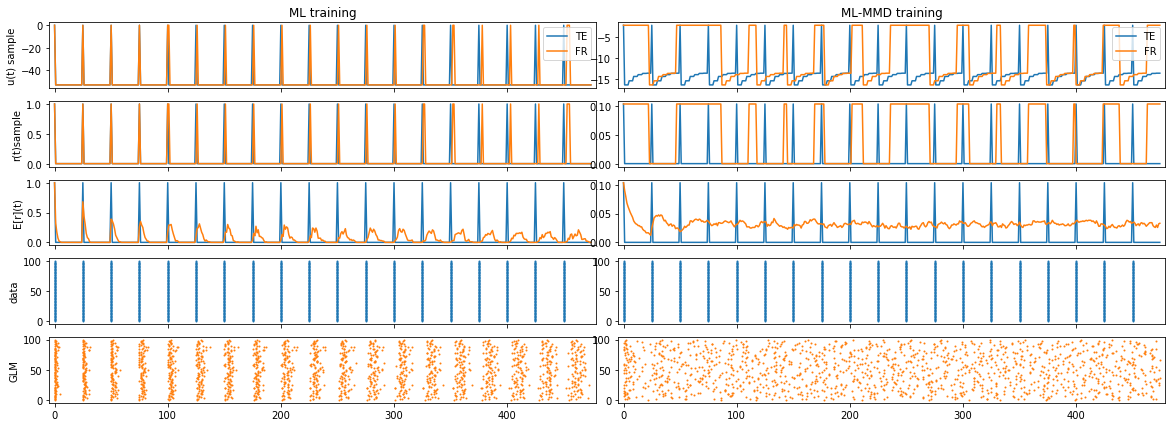

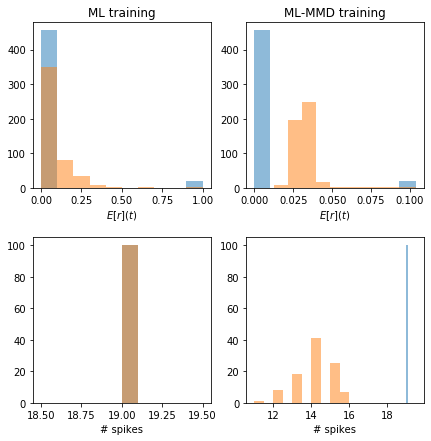

In [129]:
lam_mmd, num_epochs, lr = 1e4, 200, 1e-1
optim_pars = dict(lr=lr, betas=(0.9, 0.999))

# eta_ml = KernelRect(tbins=[0, tf_eta], coefs=eta_vals_ml.copy())
tbins = np.arange(0, 28, 4)
eta_ml = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1) - 12)

wglm = MMDGLM(u0=float(u0_ml), eta=eta_ml.copy())
# wglm = MMDGLM(u0=-2, eta=KernelRect(tbins=[0, tf_eta], coefs=[12]))

loss, mmd, n_spikes = wglm.train(t, mask_spikes_te, y, distance, lam_mmd=lam_mmd, optim_pars=optim_pars, num_epochs=num_epochs, 
                                 n_batch_fr=n_batch_fr, verbose=True, mmd_kwargs=dict(sd=1e10))
loss, mmd, n_spikes = np.array(loss), np.array(mmd), np.array(n_spikes)

u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, shape=(n_batch_fr,))
u_new_te, r_new_te = wglm.sample_conditioned(t, mask_spikes_te)

mask_spikes_new = np.concatenate((mask_spikes_te, mask_spikes_new_fr), axis=1)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)
mask_spikes_new = torch.from_numpy(mask_spikes_new).double()
u_new = torch.from_numpy(np.concatenate((u_new_te, u_new_fr), axis=1)).double()
r_new = np.concatenate((r_new_te, r_new_fr), axis=1)
r_new = torch.from_numpy(r_new)

fig1, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 5), ncols=5)
fig1.suptitle('lam_mmd=' + str(lam_mmd) + '   lw=' + str(lr))
ti = np.arange(wglm.eta.support[0], 50, .1)
vals_ml = eta_ml.interpolate(ti) + u0_ml
vals = wglm.eta.interpolate(ti) + wglm.u0
ax0.plot(ti, vals_ml, color='C2', label='ML')
ax0.plot(ti, vals, color='C4', label='ML-MMD')
ax0.set_title('bias+post-spike')
ax0.legend()
ax1.plot(loss)
ax1.set_title('loss')
ax2.plot(loss - mmd)
ax2.set_title('neg log-likelihood')
ax3.plot(mmd)
ax3.set_title('MMD')
ax4.plot(n_spikes)
ax4.set_title('n_spikes')

fig2, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey=False)
fig2.subplots_adjust(wspace=0.04)

ax00.set_title('ML training')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
ax20.plot(t, np.mean(r_te, 1))
ax20.plot(t, np.mean(r_fr, 1))
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax30, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_fr).plot(ax=ax40, ms=ms, color='C1')
ax00.set_ylabel('u(t) sample')
ax10.set_ylabel('r(t)sample')
ax20.set_ylabel('E[r](t)')
ax30.set_ylabel('data')
ax40.set_ylabel('GLM')

ax01.set_title('ML-MMD training')
ax01.plot(t, u_new_te[:, 0], label='TE')
ax01.plot(t, u_new_fr[:, 0], label='FR')
ax01.legend()
ax11.plot(t, r_new_te[:, 0])
ax11.plot(t, r_new_fr[:, 0])
ax21.plot(t, np.mean(r_new_te, 1))
ax21.plot(t, np.mean(r_new_fr, 1))
SpikeTrain(t, mask_spikes_te.numpy()).plot(ax=ax31, ms=ms, color='C0')
SpikeTrain(t, mask_spikes_new_fr).plot(ax=ax41, ms=ms, color='C1')

fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
fig3.subplots_adjust(hspace=0.3)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)

ax1.set_title('ML training')
ax2.set_title('ML-MMD training')
ax1.set_xlabel('$E[r](t)$') 
ax2.set_xlabel('$E[r](t)$')
ax3.set_xlabel('# spikes')
ax4.set_xlabel('# spikes')

In [46]:
import os
name = '/home/diego/Dropbox/generative_glm/figures/mmd_fixed_freq_fit_' + str(lam_mmd) + '_' + str(num_epochs)
fig1.savefig(name + '1.pdf', transparent=True)
fig2.savefig(name + '2.pdf', transparent=True)
fig3.savefig(name + '3.pdf', transparent=True)
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [40]:
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [38]:
'pdfunite ' + name + '*.pdf ' + name + '.pdf'

'pdfunite /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1*.pdf /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1.pdf'

(0.004517, 0.004518)

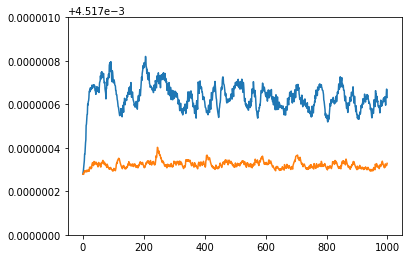

In [38]:
plt.plot(t, np.mean(r_new_te, 1))
plt.plot(t, np.mean(r_new_fr, 1))
plt.ylim(4.517e-3, 4.518e-3)

In [29]:
np.max(r_new_te)

0.004520379645401455

(array([241., 347., 163.,  95.,  55.,  50.,  20.,  20.,   6.,   3.]),
 array([0.01248375, 0.01402818, 0.01557262, 0.01711705, 0.01866149,
        0.02020592, 0.02175036, 0.02329479, 0.02483923, 0.02638366,
        0.0279281 ]),
 <a list of 10 Patch objects>)

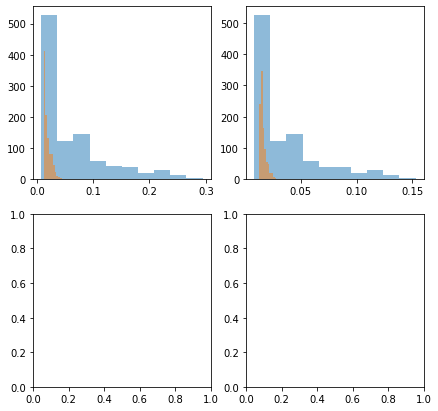

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)
# ax1.hist(output0[y == 0], alpha=0.5)
# ax2.hist(output[y == 1], alpha=0.5)
# ax2.hist(output[y == 0], alpha=0.5)

In [20]:
r.shape

torch.Size([1000, 200])